In [1]:
import json
import multiprocessing
import hashing.lsh_main as lsh
# import graph.graph_main as graph
import time
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import graph.random_walk_ori as random_walk
import pandas as pd
import lshashpy3 as lshash
import math 
from scipy import stats

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)
# data = moving_avg(data, 200).tolist()


window = 3072

nTS = 3

percentage_reconst = 70

In [2]:
# data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/Electric.csv')
# data = data['Electric'].tolist()
# df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/fake_noise_23_raw_f3.txt', header = None)

data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/Sauerstoff.csv')
data = data['Sauerstoff'].tolist()
data = stats.zscore(np.array(data))
data = data.tolist()
# data = data[:window * 6 ]
len(data)

250379

In [3]:
df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/fake_noise_23_raw_f3.txt', header = None)


## Filter GAN generated data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:03<00:00, 956.07it/s]


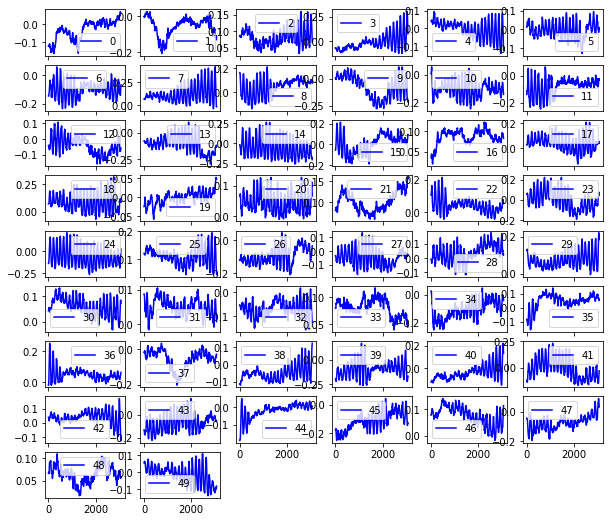

In [4]:
from scipy.signal import lfilter

df_segments = df_segments.T

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

for col in tqdm(df_segments):
#     plt.plot(df_segments[col].tolist())
    yy = lfilter(b,a,df_segments[col].tolist())
    yy[:n] = yy[n:n+1]
    df_segments[col] = yy.tolist()
#     plt.plot(df_segments[col].tolist())
#     plt.show()
    
    
# df_segments = pd.DataFrame(segments)
# df_segments = df_segments.T

df_segments.iloc[: , :50].plot(subplots=True, layout=(10,6), figsize=(10, 10), legend = True, color = 'b')
plt.show()

In [5]:
segments = [] 

for col in df_segments:
    segments += [df_segments[col].tolist()]
print(len(segments))

3072


# LSH

In [22]:

def LSH(ori, generated, window, nTS, n_top = 30, hash_length = window // 300, num_hashtables=8):
    # index synthetic segments
    lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
    for i in generated:
        lsh.index(i) 
    to_query = [ori[i:i + window] for i in range(0, len(ori) - window, window)]
    lsh_res = []
    k = int(window * .03)
    for i in tqdm(range(nTS)):
        temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
        for i in range(1, len(to_query)): 
            candidates = lsh.query(to_query[i], distance_func="euclidean", num_results=n_top)
            s = list(random.choice(candidates)[0][0])
            temp_t = temp[-k:]
            s_h = s[:k]
            overlap = []
            for i in range(-k//2, k//2):
                overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
    #         for i in range(-1*k , 0):
    #             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
    #         for i in range(0, k):
    #             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
            temp[-k:] = overlap
            s[:k] = overlap[::-1]
            temp.extend(s)
        lsh_res.append(temp)
    return lsh_res

# lsh_res= LSH(data, segments, window, nTS)


def LSH_update(ori, generated, window, nTS, n_top = 30, hash_length = window // 300, num_hashtables=8):
    # index synthetic segments
    lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
    for i in generated:
        lsh.index(i) 
    to_query = [ori[i:i + window] for i in range(0, len(ori) - window, window)]
    lsh_res = []
    used = 0
    k = int(window * .03)
    lsh_output = {}
    start = time.time()
    for i in tqdm(range(nTS)):
        current = i 
        temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
        for i in range(1, len(to_query)): 
            candidates = None
            while candidates is None: 
                try:
                    candidates = lsh.query(to_query[i], distance_func="euclidean", num_results=n_top)
                except:
                     pass
            s = list(random.choice(candidates)[0][0])
#             temp_t = temp[-k:]
#             s_h = s[:k]
#             overlap = []
#             for i in range(-k//2, k//2):
#                 overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
#     #         for i in range(-1*k , 0):
#     #             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#     #         for i in range(0, k):
#     #             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#             temp[-k:] = overlap
#             s[:k] = overlap[::-1]
            temp.extend(s)
            used += 1
        lsh_res.append(temp)
#         print(used, len(generated)*50//100)
        if used > len(generated) * percentage_reconst//100: 
            used = 0
            lsh_output[current] = time.time() - start
            print(lsh_output)
            print('lsh reconstruction...')
            lsh = lshash.LSHash(hash_length, window, num_hashtables=num_hashtables)
            for i in generated:
                lsh.index(i)    
    return lsh_res, lsh_output


# Graph

In [7]:
#Calculates the distance between two series. Given series A, B returns the Euclidean distance between A and B
def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))
    
#The probability is converted according to the sorted distances, which adds up to 1
def distopro(a):
    a=len(a)
    if(a==3):
        b=[0.2,0.3,0.5]
    elif(a==4):
        b=[0.1,0.2,0.3,0.4]
    else:
        b=[0.04,0.12,0.2,0.28,0.36]
    return np.array(b)
        

#Input is the original data matrix, return is the relationship matrix relation_matrix, and probability matrix probability_matrix
#Data is the matrix of series, the first dimension is the number of series, and the second dimension is each series
#Window_size is the size of the window to calculate the distance, and k is the number of the nearest neighbors selected. Currently, 3,4,5 are supported
def transform(data, window_size, k):
    numOfSeq=data.shape[0]
    distance_matrix=np.ones([numOfSeq,numOfSeq],dtype = float)
    for i in range(numOfSeq):
        for j in range(numOfSeq):
            distance_matrix[i][j]=distance(data[i,data.shape[1]-window_size:],data[j,0:window_size])
    relation_matrix=np.ones([numOfSeq,k],dtype = int)
    subdistance_matrix=np.ones([numOfSeq,k],dtype = float)
    probability_matrix=np.ones([numOfSeq,k],dtype = float)
    for i in range(numOfSeq):
        relation_matrix[i]=distance_matrix[i].argsort()[::-1][data.shape[0]-k:]
        #print(relation_matrix[i])
#     print(relation_matrix[i])
    for i in range(numOfSeq):
        for j in range(k):
            subdistance_matrix[i][j]=distance_matrix[i][relation_matrix[i][j]]
    
    for i in range(numOfSeq):
        probability_matrix[i]=distopro(subdistance_matrix[i])
    
    
    return distance_matrix, subdistance_matrix ,relation_matrix, probability_matrix
            
      
#print(transform(np.array([[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]]), 2, 3))


#Given the ID of the current series, the ID of the next series is generated randomly according to probability
def next_step(relation_array, probability_array):
    value=random.random()
#     print(value)
    threshold=[0]
    sum_value=0
    for i in range(len(probability_array)):
        sum_value=sum_value+probability_array[i]
        threshold.append(sum_value)
    for i in range(len(threshold)-1):
        if(value>threshold[i] and value<=threshold[i+1]):
            return relation_array[i]

#Given a relation matrix and a probability matrix, returns a series of length        
def random_walk(relation_matrix, probability_matrix, length):
    seq=[0]
    temp_id=0
    for i in range(length-1):
        temp_id=next_step(relation_matrix[temp_id],probability_matrix[temp_id])
        seq.append(temp_id)
        #print(temp_id)
    return np.array(seq)


def Graph(ori, generated, window, nTS):
    a,b,c,d=transform(np.array(generated), 100, 5)
    graph_res = []
    for i in range(nTS):
        path = random_walk( c, d, int(len(ori)/window))
#         print(path)
        temp=[]
        for s in path:
    #         print(path[i], i)
            temp+=list(generated[s])
        graph_res.append(temp)
#     print(len(graph_res))   
    return graph_res
    
def Graph_update(ori, generated, window, nTS):
    used = 0
    graph_res = []
    graph_output = {}
    start = time.time()
    a,b,c,d=transform(np.array(generated), 100, 5)
    for i in tqdm(range(nTS)):
        currentTS = i
        path = random_walk( c, d, int(len(ori)/window))
#         print(path)
        temp=[]
        for s in path:
    #         print(path[i], i)
            temp+=list(generated[s])
            used +=1
        graph_res.append(temp)
#         print(used, len(generated)*50//100)
        if used > len(generated) * percentage_reconst//100: 
            used = 0
            graph_output[currentTS] = time.time() - start
            print(graph_output)
            print('graph reconstruction...')
            a,b,c,d=transform(np.array(generated), 100, 5)
#         print(len(graph_res))   
    return graph_res, graph_output
    

In [8]:
long_seg = (4*segments)[:10000]

In [9]:
# graph_res = []
# for i in range(nTS):
#     path = random_walk( c, d, int(len(data)/window))
#     print(path)
#     temp=[]
#     for s in path:
# #         print(path[i], i)
#         temp+=list(segments[s])
#     graph_res.append(temp)
#     print(len(graph_res))

# Experiment I - Construction Runtime

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


<AxesSubplot:>

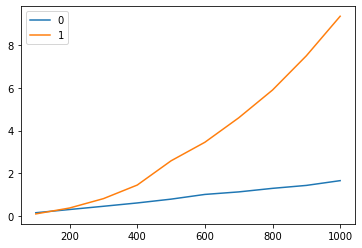

In [10]:
lsh_const = {}
graph_const = {}
for nSeg in tqdm(range(100, 1000 + 1 , 100)):
    segments = long_seg[:nSeg]
    # LSH 
    start = time.time()
    lsh = lshash.LSHash(window // 300, 3072, num_hashtables=8)
    for i in (segments):
        lsh.index(i) 
    lsh_const[nSeg] = time.time() - start
    
    # Graph
    start = time.time()
    a,b,c,d=transform(np.array(segments), 100, 5)
    graph_const[nSeg] = time.time() - start

pd.DataFrame([lsh_const, graph_const]).T.plot()

In [11]:
lsh_const, graph_const

({100: 0.1614983081817627,
  200: 0.312516450881958,
  300: 0.4633140563964844,
  400: 0.6188888549804688,
  500: 0.7967550754547119,
  600: 1.0170044898986816,
  700: 1.1348130702972412,
  800: 1.3007380962371826,
  900: 1.4379048347473145,
  1000: 1.6606080532073975},
 {100: 0.106597900390625,
  200: 0.38326478004455566,
  300: 0.8201375007629395,
  400: 1.4548797607421875,
  500: 2.587308645248413,
  600: 3.4535748958587646,
  700: 4.594775915145874,
  800: 5.892690658569336,
  900: 7.491515159606934,
  1000: 9.339110136032104})

# Experiment II - Input Segments Runtime

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8/10 [00:36<00:09,  4.53s/it]

{8: 40.97412300109863}
lsh reconstruction...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.54s/it]

  0%|                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

{8: 10.827097415924072}
graph reconstruction...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]

{1000: 47.009690046310425} {1000: 21.667396306991577}


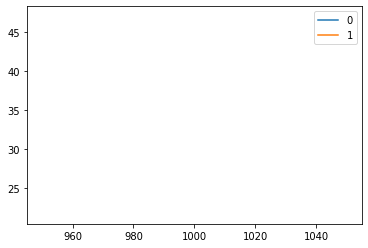

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.62s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.35it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523} {1000: 21.667396306991577, 2000: 35.98327398300171}


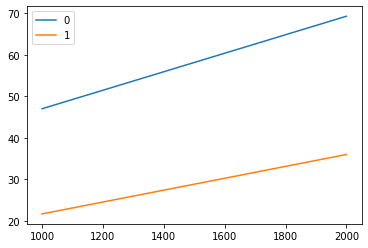

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.01s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 157.12it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694}


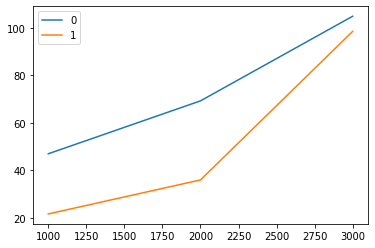

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.77s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 190.89it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651}


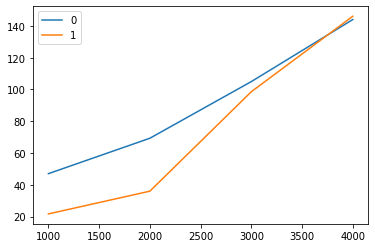

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 153.53it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123}


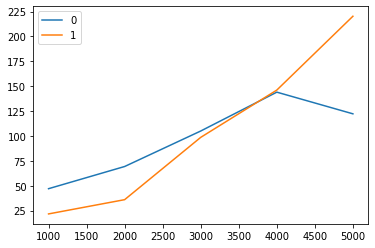

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 201.83it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741}


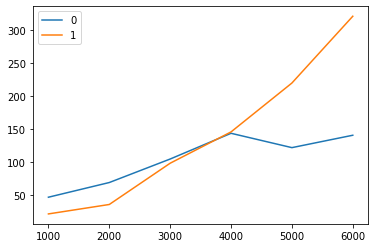

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.63s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 199.05it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074, 7000: 177.1388921737671} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741, 7000: 430.54556345939636}


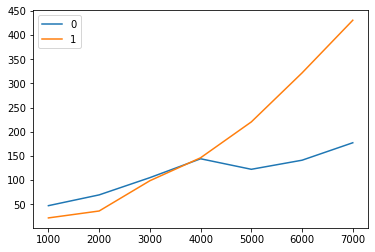

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:24<00:00, 14.49s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 205.28it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074, 7000: 177.1388921737671, 8000: 157.30989360809326} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741, 7000: 430.54556345939636, 8000: 563.2494158744812}


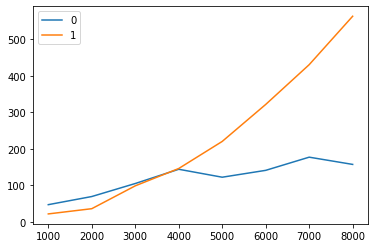

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 210.83it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074, 7000: 177.1388921737671, 8000: 157.30989360809326, 9000: 156.94471383094788} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741, 7000: 430.54556345939636, 8000: 563.2494158744812, 9000: 727.4647109508514}


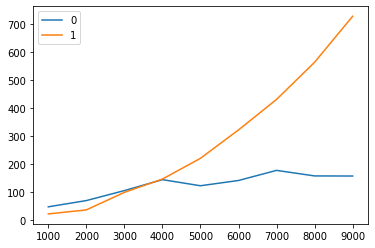

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.86s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 183.86it/s]


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074, 7000: 177.1388921737671, 8000: 157.30989360809326, 9000: 156.94471383094788, 10000: 174.40842747688293} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741, 7000: 430.54556345939636, 8000: 563.2494158744812, 9000: 727.4647109508514, 10000: 1091.0992119312286}


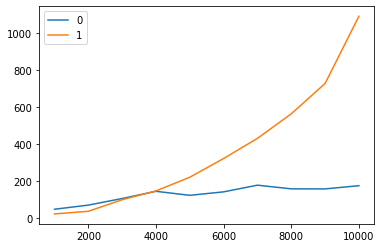

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:22:33<00:00, 495.34s/it]


In [12]:
lsh_input = {}
graph_input = {}
for nSeg in tqdm(range(1000, 10000 + 1 , 1000)):
    segments = long_seg[:nSeg]
    # LSH 
    start = time.time()
    lsh_res, _ = LSH_update(data, segments, window, nTS=10)
    lsh_input[nSeg] = time.time() - start
    # Graph
    start = time.time()
    graph_res, _ = Graph_update(data, segments, window, nTS=10)
    graph_input[nSeg] = time.time() - start

    print(lsh_input, graph_input)
    pd.DataFrame([lsh_input, graph_input]).T.plot()
    plt.show()


In [13]:
print(lsh_input, graph_input)


{1000: 47.009690046310425, 2000: 69.2991213798523, 3000: 104.96234917640686, 4000: 144.0019383430481, 5000: 122.23432683944702, 6000: 141.03686594963074, 7000: 177.1388921737671, 8000: 157.30989360809326, 9000: 156.94471383094788, 10000: 174.40842747688293} {1000: 21.667396306991577, 2000: 35.98327398300171, 3000: 98.58397817611694, 4000: 146.0897355079651, 5000: 220.26899242401123, 6000: 321.5980498790741, 7000: 430.54556345939636, 8000: 563.2494158744812, 9000: 727.4647109508514, 10000: 1091.0992119312286}


# Experiment III - Output Segments Runtime

In [16]:
nTS = 1000

In [23]:
# LSH 

lsh_res, lsh_output = LSH_update(data, long_seg, window, nTS=nTS, num_hashtables=3, n_top = 1)
lsh_output

  9%|████████████████████████████▎                                                                                                                                                                                                                                                                                                        | 87/1000 [04:33<48:00,  3.16s/it]

{87: 276.3164575099945}
lsh reconstruction...


  9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                        | 88/1000 [04:48<49:54,  3.28s/it]


IndexError: Cannot choose from an empty sequence

In [ ]:
# Graph

graph_res, graph_output = Graph_update(data, long_seg, window, nTS=nTS)
graph_output

In [ ]:
print(lsh_output, graph_output)

pd.DataFrame([lsh_output, graph_output]).T.plot()
plt.show()